# ***Assignment - 2 (NN)***

# **Importing the Libraries :**

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# **Generating Data with 5 Classes :**

In [2]:
def generate_data(samples_per_class=180):
    np.random.seed(32)
    class1 = np.random.randn(samples_per_class, 2) + np.array([2, 2])
    class2 = np.random.randn(samples_per_class, 2) + np.array([6, 6])
    class3 = np.random.randn(samples_per_class, 2) + np.array([10, 2])
    class4 = np.random.randn(samples_per_class, 2) + np.array([2, 8])
    class5 = np.random.randn(samples_per_class, 2) + np.array([10, 8])

    X = np.vstack([class1, class2, class3, class4, class5])
    y = np.array([0]*samples_per_class + [1]*samples_per_class + [2]*samples_per_class +
                 [3]*samples_per_class + [4]*samples_per_class)
    return X, y

X, y = generate_data()

# **Visualizing the data :**

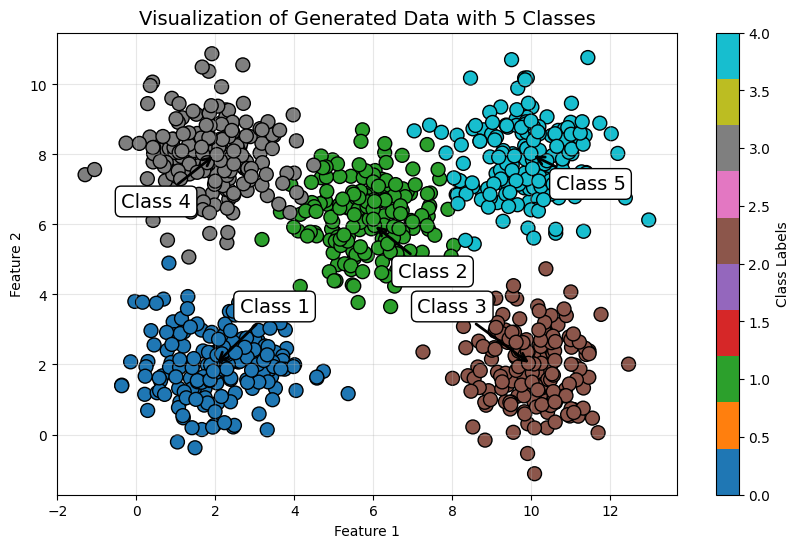

In [3]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="tab10", s=100, edgecolor="k")

centers = [(2, 2), (6, 6), (10, 2), (2, 8), (10, 8)]
offsets = [(1.5, 1.5), (1.5, -1.5), (-2, 1.5), (-1.5, -1.5), (1.5, -1)]

for i, (center, offset) in enumerate(zip(centers, offsets)):
    plt.annotate(f'Class {i + 1}',
                 xy=center,
                 xytext=(center[0] + offset[0], center[1] + offset[1]),
                 arrowprops=dict(facecolor='black', arrowstyle='->', lw=2),
                 fontsize=14,
                 ha="center",
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.title("Visualization of Generated Data with 5 Classes", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(alpha=0.3)
plt.colorbar(scatter, label="Class Labels")
plt.show()

# **Encoding the Labels :**

In [4]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# **Spliting the Data :**

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=32)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=32)

# **Creating the Neural Networks :**

In [6]:
class NeuralNet:
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, lr):
        self.W1 = np.random.randn(input_size, hidden_size1)
        self.W2 = np.random.randn(hidden_size1, hidden_size2)
        self.W3 = np.random.randn(hidden_size2, hidden_size3)
        self.W4 = np.random.randn(hidden_size3, output_size)
        self.lr = lr

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feed_forward(self, x):
        self.hidden_input1 = np.dot(x, self.W1)
        self.hidden_output1 = self.sigmoid(self.hidden_input1)

        self.hidden_input2 = np.dot(self.hidden_output1, self.W2)
        self.hidden_output2 = self.sigmoid(self.hidden_input2)

        self.hidden_input3 = np.dot(self.hidden_output2, self.W3)
        self.hidden_output3 = self.sigmoid(self.hidden_input3)

        self.output_input = np.dot(self.hidden_output3, self.W4)
        self.output = self.softmax(self.output_input)
        return self.output

    def backprop(self, x, y, output):
        output_delta = output - y  # softmax + cross-entropy

        hidden_error3 = np.dot(output_delta, self.W4.T)
        hidden_delta3 = hidden_error3 * self.sigmoid(self.hidden_output3, derivative=True)

        hidden_error2 = np.dot(hidden_delta3, self.W3.T)
        hidden_delta2 = hidden_error2 * self.sigmoid(self.hidden_output2, derivative=True)

        hidden_error1 = np.dot(hidden_delta2, self.W2.T)
        hidden_delta1 = hidden_error1 * self.sigmoid(self.hidden_output1, derivative=True)

        self.W4 -= np.dot(self.hidden_output3.T, output_delta) * self.lr
        self.W3 -= np.dot(self.hidden_output2.T, hidden_delta3) * self.lr
        self.W2 -= np.dot(self.hidden_output1.T, hidden_delta2) * self.lr
        self.W1 -= np.dot(x.T, hidden_delta1) * self.lr

    def train(self, x, y):
        output = self.feed_forward(x)
        self.backprop(x, y, output)

# **Training the Model :**

In [7]:
input_size = X_train.shape[1]
hidden_size1 = hidden_size2 = hidden_size3 = 20
output_size = y_train.shape[1]
lr = 0.0015
epochs = 500

nn = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, lr)
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    nn.train(X_train, y_train)
    train_output = nn.feed_forward(X_train)
    val_output = nn.feed_forward(X_val)

    train_loss = -np.mean(np.sum(y_train * np.log(train_output + 1e-9), axis=1))
    val_loss = -np.mean(np.sum(y_val * np.log(val_output + 1e-9), axis=1))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_output, axis=1))
    val_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_output, axis=1))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_accuracy*100:.2f}%, Val Acc={val_accuracy*100:.2f}%")

Epoch 0: Train Loss=2.6620, Val Loss=2.6669, Train Acc=20.93%, Val Acc=19.44%
Epoch 100: Train Loss=0.4294, Val Loss=0.4722, Train Acc=84.63%, Val Acc=81.11%
Epoch 200: Train Loss=0.7703, Val Loss=0.7790, Train Acc=72.59%, Val Acc=71.67%
Epoch 300: Train Loss=0.2710, Val Loss=0.3039, Train Acc=90.74%, Val Acc=88.33%
Epoch 400: Train Loss=0.2465, Val Loss=0.2844, Train Acc=92.04%, Val Acc=90.56%


# **Plotting the Loss & Accuracy :**

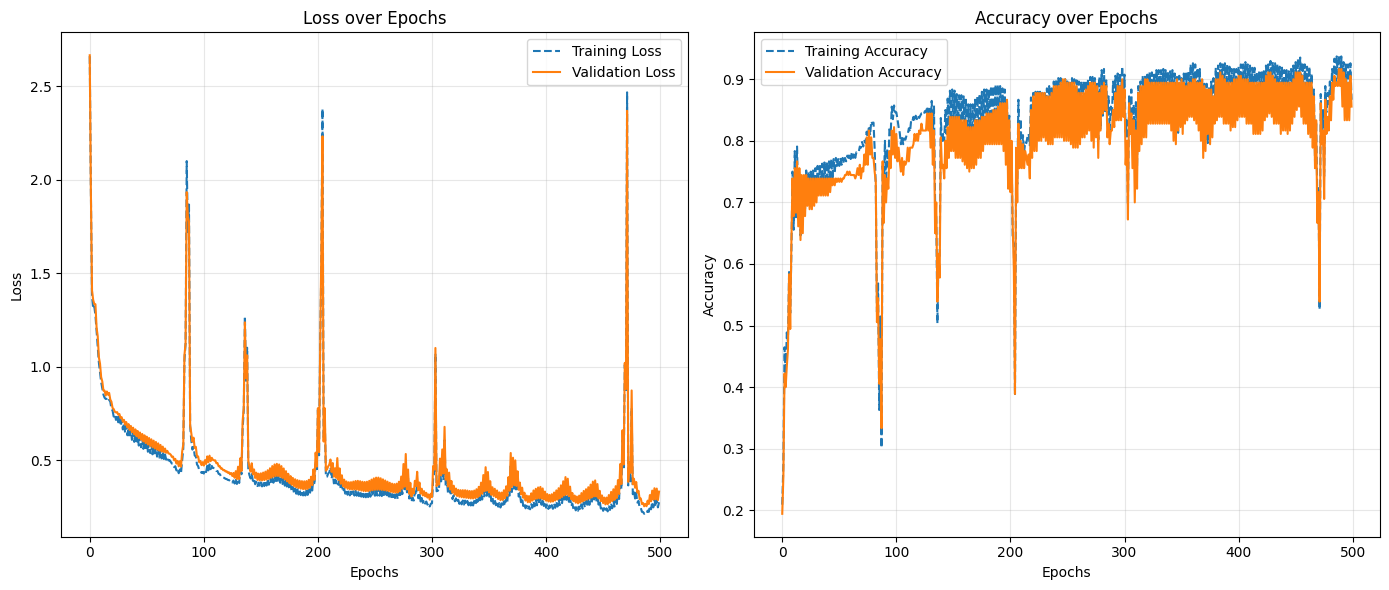

In [8]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", linestyle='--')
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", linestyle='--')
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# **Accuracy of TEST :**

In [11]:
test_output = nn.feed_forward(X_test)
predicted_classes = np.argmax(test_output, axis=1)
actual_classes = np.argmax(y_test, axis=1)
test_accuracy = accuracy_score(actual_classes, predicted_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 91.11%


# **Visualization of the Predictions :**

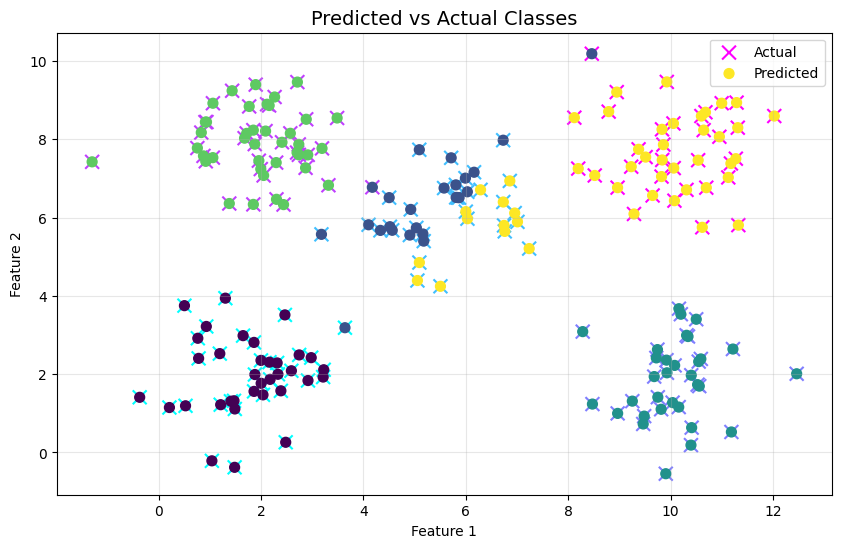

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=actual_classes, cmap='cool', s=100, marker='x', label='Actual')
plt.scatter(X_test[:, 0], X_test[:, 1], c=predicted_classes, cmap='viridis', s=50, marker='o', label='Predicted')
plt.title("Predicted vs Actual Classes", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# **The Decision Boundary :**

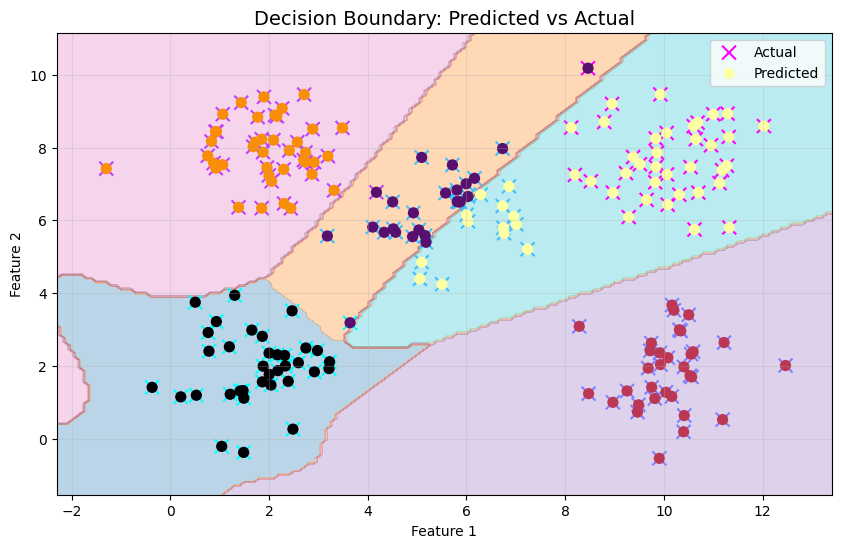

In [13]:
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = np.argmax(nn.feed_forward(np.c_[xx.ravel(), yy.ravel()]), axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab10')
plt.scatter(X_test[:, 0], X_test[:, 1], c=actual_classes, cmap='cool', s=100, marker='x', label='Actual')
plt.scatter(X_test[:, 0], X_test[:, 1], c=predicted_classes, cmap='inferno', s=50, marker='o', label='Predicted')
plt.title("Decision Boundary: Predicted vs Actual", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# **The Classification Report :**

In [14]:
y_true = actual_classes
y_pred = predicted_classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(5)]))


Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.97      0.99        36
     Class 1       0.88      0.63      0.73        35
     Class 2       1.00      1.00      1.00        32
     Class 3       1.00      0.98      0.99        41
     Class 4       0.73      0.97      0.83        36

    accuracy                           0.91       180
   macro avg       0.92      0.91      0.91       180
weighted avg       0.92      0.91      0.91       180



# **Visualizing the Confusion Matrix :**

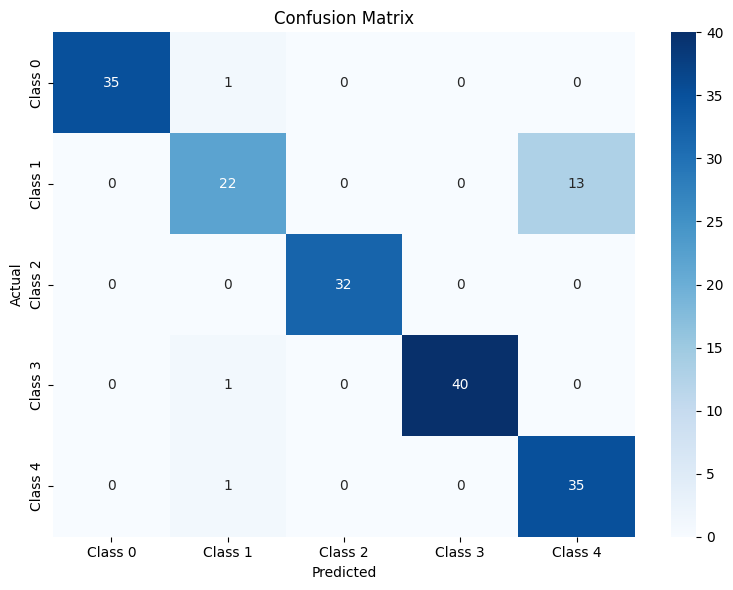

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, cmap="Blues", fmt="d",
            xticklabels=[f"Class {i}" for i in range(5)],
            yticklabels=[f"Class {i}" for i in range(5)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# **Conclusion :**

1. Modification's justification :
The code was changed to create synthetic data with five different classes using make_classification so implementing multi-class classification. One-hot encoding the class labels using OneHotEncoder then lets the network produce a probability distribution spanning all classes. Three hidden layers using ReLU activation were built into the neural network architecture to provide non-linearity, then an output layer comprising five neurons with softmax activation to guarantee class probabilities. Since the categorical cross-entropy loss function fits multi-class classification challenges rather well. The class with the highest probability chose itself during prediction. Accuracy, a confusion matrix, and a classification report with precision, recall, and F1-scores helped one evaluate the model.


2. Key Finding Summary :
With reasonable accuracy and generally balanced performance across classes, the results showed that the model learnt to categorize inputs into the proper groups rather effectively. Although some misclassifications did arise, presumably from overlapping features or small class imbalances in the synthetic dataset, the confusion matrix and classification metrics revealed that the model performed well for most classes.


3. Difficulties and Acquired Knowledge :
Several difficulties arose during the deployment. Choosing suitable weight initialization techniques and learning rates turned out to be crucial since bad decisions might prevent convergence. Especially with softmax and cross-entropy derivatives, debugging matrix dimensions during forward and backward passes was also a regular challenge. Furthermore emphasized by the overfitting risk was the need of regularizing even in synthetic environments.


4. Possible Development or Additional Research Projects :
Many developments could be investigated in order to improve performance. While trying more advanced optimizers like Adam or RMSprop might improve convergence, adding dropout or L2 regularization could help prevent overfitting. Deeper insight and resilience could also come from using hyperparameter tuning, assessing the model on real-world data, and visualizing training curves. All things considered, the project gave insightful analysis of both implementation methods and areas of future research as well as useful experience in building and improving a neural network for multi-class classification.